# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [49]:
!pip install -r requirements.txt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: line 1: pip: command not found


In [50]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

## Ignore the warnings below

Using device: cuda
GPU: NVIDIA GeForce RTX 5090 Laptop GPU
CUDA Version: 12.8


The following code block contains an 8x8 matrix that will be used as a maze object:

In [51]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [52]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [53]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


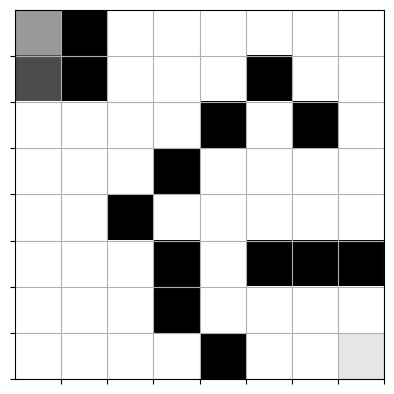

In [54]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [55]:
def play_game(model, qmaze, pirate_cell):
    """Play a single game using the trained model"""
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        with torch.no_grad():
            state_tensor = torch.FloatTensor(prev_envstate).to(device)
            q = model(state_tensor)
            action = torch.argmax(q[0]).item()

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [56]:
def completion_check(model, qmaze):
    """Check if the model can win from all starting positions"""
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [57]:
# PyTorch Q-Network Model
class QNetwork(nn.Module):
    def __init__(self, input_size, num_actions):
        super(QNetwork, self).__init__()
        self.num_actions = num_actions

        self.fc1 = nn.Linear(input_size, input_size)
        self.prelu1 = nn.PReLU()
        self.fc2 = nn.Linear(input_size, input_size)
        self.prelu2 = nn.PReLU()
        self.fc3 = nn.Linear(input_size, num_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = self.prelu1(x)
        x = self.fc2(x)
        x = self.prelu2(x)
        x = self.fc3(x)
        return x

def build_model(maze):
    """Build PyTorch Q-Network"""
    model = QNetwork(maze.size, num_actions).to(device)
    return model

In [59]:
def qtrain(model, maze, **opt):
    """
    Train the Q-Network using deep Q-learning with PyTorch
    """
    # number of epochs
    n_epoch = opt.get('n_epoch', 1000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 15000)

    # maximum data size for training
    data_size = opt.get('data_size', 32)

    # frequency of target network updates
    target_update_freq = opt.get('target_update_freq', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze
    qmaze = TreasureMaze(maze)

    # Create target network for stable Q-learning
    target_model = copy.deepcopy(model)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    # Initialize experience replay object with target network
    experience = GameExperience(model, target_model, max_memory=max_memory, device=device)

    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0

    # Epsilon decay parameters
    epsilon = 0.9  # Start with 90% exploration
    epsilon_min = 0.1  # Minimum exploration rate
    epsilon_decay = 0.99  # Decay rate per epoch

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(n_epoch):
        loss_value = 0.0
        # choose a random free cell to start
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        # get the initial state of the environment
        envstate = qmaze.observe()
        n_steps = 0
        game_over = False

        # episode of game play
        while not game_over:
            # get valid actions in the current state
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break

            prev_envstate = envstate

            # choose action by exploration or exploitation
            if np.random.rand() < epsilon:
                # explore: select a random valid action
                action = random.choice(valid_actions)
            else:
                # exploit: select the action with max Q value
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(prev_envstate).to(device)
                    q_values = model(state_tensor)
                    action = torch.argmax(q_values[0]).item()

            # apply action, get rewards and new game status
            envstate, reward, game_status = qmaze.act(action)

            # determine if game is over (boolean for GameExperience)
            game_over = (game_status == 'win') or (game_status == 'lose')

            # store the episode with game_over as boolean
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)

            n_steps += 1

            # Train
            if len(experience.memory) >= data_size:
                inputs, targets = experience.get_data(data_size=data_size)

                # Convert to PyTorch tensors
                inputs_tensor = torch.FloatTensor(inputs).to(device)
                targets_tensor = torch.FloatTensor(targets).to(device)

                # Forward pass
                model.train()
                predictions = model(inputs_tensor)

                # Compute loss
                loss = criterion(predictions, targets_tensor)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                loss_value = loss.item()

        # record win/loss in history after episode completes
        if game_status == 'win':
            win_history.append(1)
        elif game_status == 'lose':
            win_history.append(0)

        # Update target network periodically
        if epoch % target_update_freq == 0:
            target_model.load_state_dict(model.state_dict())

        # calculate win rate
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        else:
            win_rate = sum(win_history) / len(win_history) if len(win_history) > 0 else 0.0

        # Decay epsilon after each epoch
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Steps: {:d} | Win count: {:d} | Win rate: {:.3f} | epsilon: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss_value, n_steps, sum(win_history), win_rate, epsilon, t))

        # check if training has exhausted all free cells and if in all cases the agent won
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

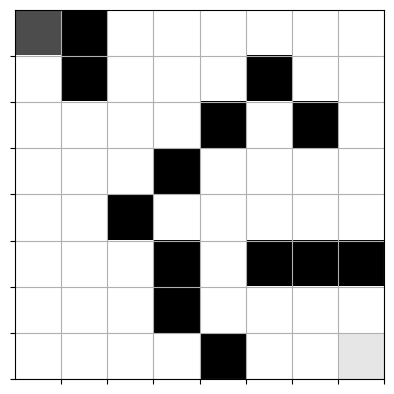

In [60]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [61]:
def randomly_select_free_cell(qmaze):
    # Find all free (non-wall) cells in the maze
    free_cells = [(r, c) for r in range(qmaze.rows)
                         for c in range(qmaze.cols)
                         if qmaze.maze[r, c] == 0]  # assuming 0 means free
    return random.choice(free_cells)

In [62]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=1000, data_size=32)

Epoch: 000/999 | Loss: 0.0014 | Steps: 144 | Win count: 0 | Win rate: 0.000 | epsilon: 0.891 | time: 1.9 seconds
Epoch: 001/999 | Loss: 0.0019 | Steps: 155 | Win count: 0 | Win rate: 0.000 | epsilon: 0.882 | time: 4.5 seconds
Epoch: 002/999 | Loss: 0.0018 | Steps: 145 | Win count: 0 | Win rate: 0.000 | epsilon: 0.873 | time: 7.0 seconds
Epoch: 003/999 | Loss: 0.0016 | Steps: 160 | Win count: 0 | Win rate: 0.000 | epsilon: 0.865 | time: 9.6 seconds
Epoch: 004/999 | Loss: 0.0014 | Steps: 140 | Win count: 0 | Win rate: 0.000 | epsilon: 0.856 | time: 11.9 seconds
Epoch: 005/999 | Loss: 0.0017 | Steps: 68 | Win count: 1 | Win rate: 0.167 | epsilon: 0.847 | time: 13.0 seconds
Epoch: 006/999 | Loss: 0.0018 | Steps: 160 | Win count: 2 | Win rate: 0.286 | epsilon: 0.839 | time: 15.6 seconds
Epoch: 007/999 | Loss: 0.0013 | Steps: 62 | Win count: 3 | Win rate: 0.375 | epsilon: 0.830 | time: 16.6 seconds
Epoch: 008/999 | Loss: 0.0018 | Steps: 147 | Win count: 3 | Win rate: 0.333 | epsilon: 0.822 |

381.711869

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

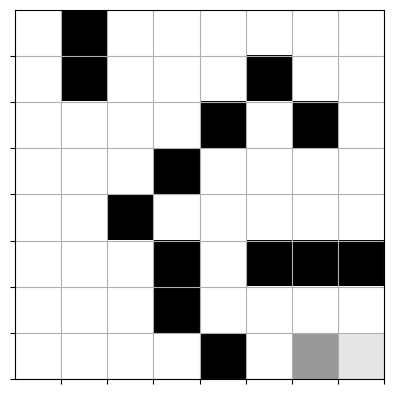

In [63]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

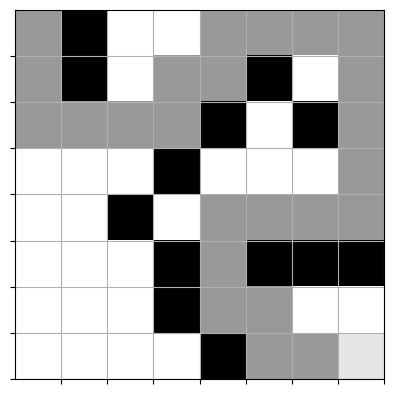

In [64]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.